### Find equation parameters to fit data via MCMC ###
2/17/23

#### Project Plan ####
1. Define problem
2. Create artifical observational data
3. Choose Posterior Density Function
4. Choose Proposal Distribution
5. Specify prior ranges for the parameters
6. MCMC Metropolis Hastinging Algorithm
7. Model Efficiency and convergence
8. Summary

#### 1. Define problem and desired output ####

**Intent:**

To test my understanding and implementation of MCMC, I created artificial observations from a known function, f(x) = exp(x^1.25).

**Business Problem:**

This exercise isn't tied to a real business problem, but to understand better the real-world applicable of MCMC and the types of business problems it can help answer, I created a made-up business problem behind the data. Our artifical observational data will represent **exponential bacterial hourly growth rate in a specific habitat**. 

I would like to be able to answer the following questions:

1. What is the expected average bacteria amount for this habitat?
2. What is the probability that the bacteria population is greater than 8 in this habitat?
3. What is the likelihood that a newly observed bacteria sample is part of this same population?

In [3]:
# import packages
import numpy as np
import statistics
import math
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt

colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

#### 2. Create artifical observational data ####

In [4]:
# generate a dataset that follows this equation generally to simulate
# as if we were to collect data that was shaped in a way to fit this function
x=[]
r=[]
fx=[]

# equation to generate the observations
def equation(x,r):
    f=math.exp(x**r)
    return f

# generate observations
for i in range(2000):
    random_x=np.random.uniform(1,2)
    random_r=round(np.random.uniform(1.22, 1.26),2)
    x.append(random_x)
    r.append(random_r)
    #print(random_x)
    #print(random_r)
    f=equation(random_x,random_r)
    fx.append(f)
    
# Save observations in dataframe
data=pd.DataFrame({'sq_in':x, 'bact_pop':fx, 'r':r})
data.head()

,sq_in,bact_pop,r
0,1.418967,4.679932,1.24
1,1.524880,5.367024,1.23
2,1.525370,5.408918,1.24
3,1.632789,6.275659,1.24
4,1.191595,3.465284,1.24


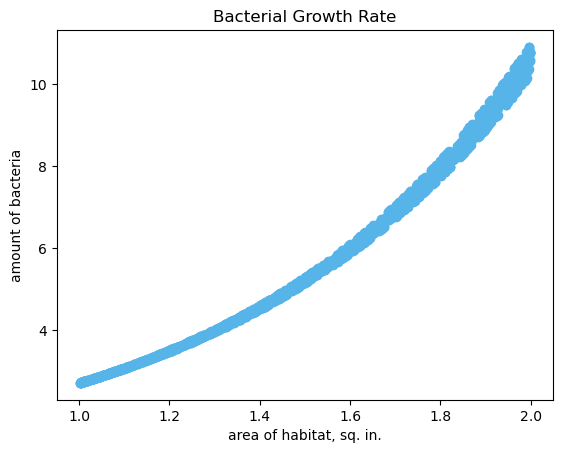

In [5]:
# plot of observational data
plt.scatter(data.sq_in, data.bact_pop, color=colors[6])
plt.xlabel("area of habitat, sq. in.")
plt.ylabel("amount of bacteria")
plt.title("Bacterial Growth Rate")
plt.show()

Plot probability distribution of observational data

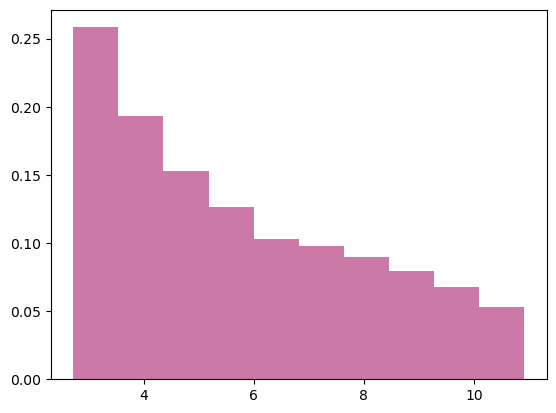

In [6]:
# Plot probability distribution of bacteria amount
plt.hist(data.bact_pop,density=True, color=colors[5])
plt.show()

#### 3. Choose Posterior Density Function ####

Based on the probability distribution of bacteria amount the shape matches an exponential distribution. The PDF is expressed as:

f(d; L) = L * e^(-L * d)

where _L_ represents lambda, the parameter we want to estimate

**Posterior Likelihood:**

Using the exponential PDF as our posterior density function, we can estimate the likelihood of seeing our observations (specifically the bacterial amount) given a specific value of _L_. The likelihood gives insight into which _L_ values fit the observational data better. I will use the log likelihood since some of the output values can be extremely small.

In [7]:
def log_posterior_likelihood(data_y, L):
    densities=[]
    for d in data_y.tolist():
        out=math.log(L * math.exp(-L * d))
        densities.append(out)
    
    # when finding log likelihood, densities are summed, not multiplied
    log_likelihood=sum(densities)
    return(log_likelihood)

#### 4. Choose Proposal Distribution ####

For drawing the next proposal parameter value, I'll use the Gaussian distribution with mean at current position and a set standard deviation, N~(xi, sd=2).

Since the mean of the distribution will be current position and the standard deviation is fixed, this proposal distribution is symmetric so the ratio of proposal densities is 1.

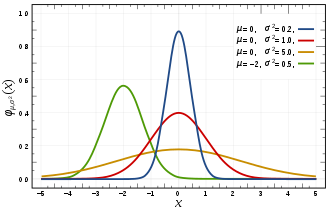


In [8]:
##### Proposal Distribution #####
def gaussian_proposal(x, sigma=2):
    # For random samples from the normal distribution with mean mu and standard deviation sigma, use:
    x_next = sigma * np.random.randn() + x

    return (x_next)

In [9]:
def log_gaussian_likelihood(x_current, x_next, sigma=2):
    # the proposal distribution is symmetric so the ratio of proposal densities g(.) is 1, but including the math for transparency
    
    # g(xi | x*)
    log_g_num= math.log((math.exp(-((x_current-x_next)**2) / (2*sigma)))/(sigma * math.sqrt(2*math.pi)))
    
    # g(x* | xi)
    log_g_denom= math.log((math.exp(-((x_next-x_current)**2) / (2*sigma)))/(sigma * math.sqrt(2*math.pi)))
    
    log_g_likelihood=log_g_num - log_g_denom
    
    return(log_g_likelihood)
    

#### 5. Specify prior ranges for the parameters ####
Since I know that _r_ should be positive and greater than 0, I will include these as parameter priors.

In [10]:
def parameter_priors_check(x):
    # r should be positive and greater than 0
    if x > 0:
        return x
    else:
        return 0

#### 6. MCMC Metropolis Hastinging Algorithm ####

**Choose Initial State**

In [11]:
##### Choose initial State #####
r0=1.5

**Metropolis Hastings Algorithm**

In [12]:
# Iterations of the algorithm
iters=1000
sd=0.1
counter=0

counter_list=[]
r_current=[]
r_next_proposed=[]
g_ratio_stored=[]
p_ratio_stored=[]
likelihood_ratio=[]
uniform_draw=[]
jump_accepted=[]


for i in np.arange(iters): #The default start value is 0
    # What chain link we are on
    counter_list.append(counter)
    
    # Current parameter (either the inital value if counter==1, or value from last chain)
    if counter==0:
        x_current=r0
        r_current.append(r0)
    else:
        x_current=r_current[i]
        
     
    
    # Next parameter proposed with Jump Proposal I
    x_next= gaussian_proposal(x_current, sigma=sd)
    r_next_proposed.append(x_next)
    
    # Calculate Acceptance Probability or Hastings Ratio after priors check
    if x_next > 0:
        # g(.)
        g_ratio= log_gaussian_likelihood(x_current, x_next, sigma=sd)
        g_ratio_stored.append(g_ratio)
        
        # p(.)
        p_ratio=log_posterior_likelihood(data_y=data.bact_pop, L=x_next) - log_posterior_likelihood(data_y=data.bact_pop, L=x_current)
        p_ratio_stored.append(p_ratio) 
        
        # hastings ratio -> p(.) * g(.) or 
        # when using log likelihood --> log(u) <= log( p(new) ) - log( p(old) ) + log( g(old) ) - log( g(new) )
        right_side_of_acceptance_equation=min(1,g_ratio + p_ratio)    
        likelihood_ratio.append(g_ratio + p_ratio)
        
    else:
        g_ratio_stored.append(0)
        p_ratio_stored.append(0)
        likelihood_ratio.append(0)
        uniform_draw.append(0)
        jump_accepted.append(0)
        if i!=(iters-1):
            r_current.append(x_current)
        else: pass
        counter += 1    
        continue
    
    # Generate a random number u from Uniform(0,1)
    u = np.random.uniform(0.0001, 1)
    uniform_draw.append(u)
    
    # Evaluate acceptance criteria
    if math.log(u) < right_side_of_acceptance_equation:
        if i==(iters-1):
            jump_accepted.append(1)
        else:
            jump_accepted.append(1)
            r_current.append(x_next)
        counter += 1
    else:
        if i==(iters-1):
            jump_accepted.append(0)
        else:
            jump_accepted.append(0)
            r_current.append(x_current)
        counter += 1

In [13]:
# Ensure all output lists are the same length before transforming into dataframe
cols=[counter_list,r_current,r_next_proposed,g_ratio_stored,p_ratio_stored,likelihood_ratio,uniform_draw,jump_accepted]

for c in cols:
    print(len(c))

1000
1000
1000
1000
1000
1000
1000
1000


In [14]:
mcmc_output=pd.DataFrame({'chain':counter_list,
                            'r_current':r_current,
                            'r_proposed_next':r_next_proposed,
                            'g_ratio':g_ratio_stored,
                            'p_ratio':p_ratio_stored,
                            'likelihood_ratio':likelihood_ratio,
                            'u':uniform_draw,
                            'jump_accepted':jump_accepted
                         })

In [15]:
mcmc_output

,chain,r_current,r_proposed_next,g_ratio,p_ratio,likelihood_ratio,u,jump_accepted
0,0,1.500000,1.414055,0.0,865.463839,865.463839,0.595765,1
1,1,1.414055,1.461336,0.0,-475.254443,-475.254443,0.809106,0
2,2,1.414055,1.325431,0.0,884.678907,884.678907,0.519236,1
3,3,1.325431,1.357036,0.0,-314.529924,-314.529924,0.588980,0
4,4,1.325431,1.315355,0.0,100.034146,100.034146,0.229320,1
...,...,...,...,...,...,...,...,...
995,995,0.174451,0.148263,0.0,-25.643453,-25.643453,0.438917,0
996,996,0.174451,0.323832,0.0,-472.203529,-472.203529,0.944943,0
997,997,0.174451,0.062343,0.0,-775.133319,-775.133319,0.675107,0
998,998,0.174451,0.195701,0.0,-13.275868,-13.275868,0.100293,0


### Estimated value for parameter _r_:

In [23]:
rs=mcmc_output[250:]["r_current"]

In [27]:
r=rs.mean()
r

0.17458653816228809

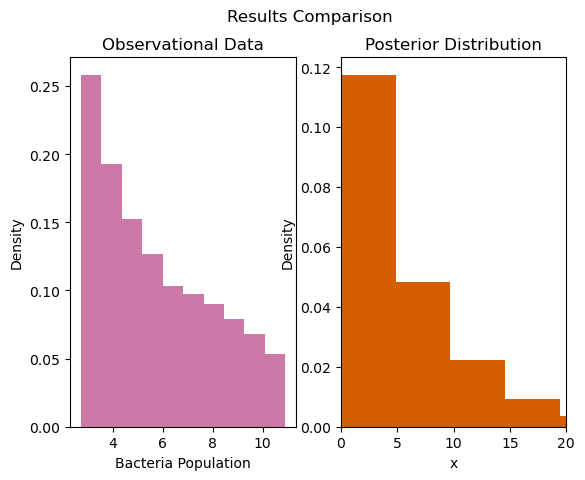

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Results Comparison')

ax1.hist(data.bact_pop,density=True, color=colors[5])
ax1.set(xlabel='Bacteria Population', 
                            ylabel='Density',
                            title='Observational Data'
                           )

ax2.hist( np.random.exponential(scale=1/r , size=1000) ,density=True, color=colors[4])
ax2.set(xlabel='x', 
        ylabel='Density',
       title='Posterior Distribution',
       xlim=(0,20))
plt.show()

### Business Questions Answered?

**1. What is the expected average bacteria amount for this habitat?**

Knowing the form and parameters of the posterior distribution, we can use the formula for the Expected Value of a Poisson disribution...

X ~ Poisson(λ)

Expected Value = lambda = 

In [36]:
# Lambda and Expected Value and Variance
r

0.17458653816228809

**2. What is the probability that the bacteria population is greater than 8 in this habitat?**

Knowing the form and parameters of the posterior distribution, we can use python's built-in Poisson CDF function...

X ~ Poisson(λ)

P(X>8) = 

In [38]:
1- stats.poisson.cdf(8, r)

3.5493830097266255e-13

**3. What is the likelihood that a newly observed bacteria sample is part of this same population?**

New obseration of population=3 comes in...

X ~ Poisson(λ)

_H0: λ=0.17_

_H1: λ!=0.17_

P(X<=3) < α, where α=0.05


In [41]:
stats.poisson.cdf(3, r) < 0.05

False

We fail to reject the Null Hypothesis and have no reason to think this obs does not come from this population.